In [1]:
!pip install torch-lr-finder

In [2]:
import torch
import torchvision
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import OneCycleLR
from functools import partial
%matplotlib inline
import cv2
from torch_lr_finder import LRFinder

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [4]:
transform = transforms.Compose([transforms.ToTensor()]) # simple ToTensor for now

train_set = torchvision.datasets.CIFAR10(root='./cifar10', download=True, train=True, transform=transform)


100%|██████████| 170498071/170498071 [00:13<00:00, 12997741.09it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10


In [5]:
train_set.data.shape # train data shape

(50000, 32, 32, 3)

In [6]:
# calculate mean and standard deviation

m = np.mean(train_set.data, axis=(0,1,2))
print(m/255)

s = np.std(train_set.data, axis=(0, 1, 2))
print(s/255)

[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [7]:
mean = m/255
sdev = s/255

In [8]:
SEED = 101

BATCH = 512

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

if cuda:
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=BATCH, num_workers=2, pin_memory=True)\
    if cuda else dict(shuffle=True, batch_size=32)


CUDA Available? True


In [9]:
from google.colab import files

In [10]:
def plot_misclassified_images(incorrect_examples, incorrect_labels, incorrect_preds):
    fig = plt.figure(figsize=(20, 8))

    for idx in np.arange(10):
      ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
      #std = np.array([0.229, 0.224, 0.225])
      #mean = np.array([0.485, 0.456, 0.406])
      img = incorrect_examples[idx][idx]
      img = img/2 + 0.5
      img = np.clip(img, 0, 1)
      imshow(img)
      ax.set_title(f"{classes[pred[idx]]}: x%\n (label: {classes[target[idx]]})",
      color=("green" if pred[idx]==target[idx].item() else "red"))

In [11]:
incorrect_examples = []
incorrect_labels = []
incorrect_preds = []

In [12]:
def train_eval_model(model, train_loader, optimizer, device, epochs=1, test=False, test_loader=None, scheduler=None, threshold=85.0, download=False):
    counter = 0
    model_name = None
    model.train() # set the train mode

    test_acc_window = [0,0,0]

    # iterate over for `epochs` epochs and keep storing valuable info

    for epoch in range(epochs):
      correct = processed = train_loss = 0

      print(f"\n epoch num ================================= {epoch+1} out of {epochs} epochs")

      pbar = tqdm(train_loader)

      for batch_idx, (data, target) in enumerate(pbar):
          data, target = data.to(device), target.to(device) # move data to `device`

          optimizer.zero_grad() # zero out the gradients to avoid accumulating them over loops

          output = model(data) # get the model's predictions

          loss = F.nll_loss(output, target) # calculate Negative Log Likelihood loss using ground truth labels and the model's predictions

          train_loss += loss.item() # add up the train loss

          loss.backward() # boom ! The magic function to perform backpropagation and calculate the gradients

          optimizer.step() # take 1 step for the optimizer and update the weights

          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

          correct += pred.eq(target.view_as(pred)).sum().item() #  compare and see how many predictions are coorect and then add up the count

          processed += len(data) # total processed data size

      acc = 100 * correct/processed

      train_losses.append(train_loss)

      train_accuracy.append(acc)

      if scheduler:
        print("\n\n\t\t\tLast LR -->", scheduler.get_last_lr())
        scheduler.step()

      pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


      train_loss /= len(train_loader.dataset)
      print('\n\t\t\tTrain metrics: accuracy: {}/{} ({:.4f}%)'.format(correct,
                                                              len(train_loader.dataset),
                                                              correct * 100 / len(train_loader.dataset)))

      if test: # moving to evaluation
          model.eval() # set the correct mode

          correct = test_loss = 0

          with torch.no_grad(): # to disable gradient calculation with no_grad context

              for data, target in test_loader:

                  data, target = data.to(device), target.to(device)

                  output = model(data)

                  test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

                  pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

                  correct += pred.eq(target.view_as(pred)).sum().item()




          test_loss /= len(test_loader.dataset)
          test_losses.append(test_loss)
          curr_test_acc = 100. * correct / len(test_loader.dataset)
          test_accuracy.append(curr_test_acc)

          test_acc_window[counter % 3] = curr_test_acc
          counter = counter + 1

          if curr_test_acc >= threshold:
              print(f"\nStoring misclassified images at: {curr_test_acc}% at epoch: {epoch}")
              misclassified_mask = ((pred == target.view_as(pred)) == False).view(-1)

              if misclassified_mask.numel():
                  incorrect_examples.append(data[misclassified_mask].squeeze().cpu().numpy())
                  incorrect_labels.append(target[misclassified_mask].cpu().numpy()) #the corresponding target to the misclassified image
                  incorrect_preds.append(pred[misclassified_mask].squeeze().cpu().numpy()) #the corresponiding predicted class of the misclassified image


          if curr_test_acc > threshold:
              if all(x > threshold for x in test_acc_window):
                  model_name = f"./85_crossed_{counter}.pth"
                  torch.save(model, model_name)


          print('\n\tTest metrics: average loss: {:.4f}, accuracy: {}/{} ({:.5f}%)\n'.format(
              test_loss, correct, len(test_loader.dataset),
              100. * correct / len(test_loader.dataset)))
    if model_name and download:
        files.download(model_name)

In [13]:
def train(model, device, train_loader, optimizer, scheduler,
          criterion, train_acc, train_loss, epoch):

    model.train()

    pbar = tqdm(train_loader)
    correct = 0
    processed = 0

    # lr_epochs.append((epoch, optimizer.param_groups[0]['lr']))
    print(f"\nEpoch num: {epoch}  |  LR: {optimizer.param_groups[0]['lr']:.10f}", end="\n")

    for batch_idx, (data, target) in enumerate(pbar):

        data, target = data.to(device), target.to(device)

        y_pred = model(data)
        loss = criterion(y_pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        acc = 100 * correct / processed

        pbar.set_description(desc=f'Loss={loss.item()} Accuracy={acc:.2f}')

    train_loss.append(loss.data.cpu().numpy().item())
    train_acc.append(acc)

def test(model, device, test_loader, test_acc, test_losses):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.5f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [14]:
def plot_graphs(*, train_losses, train_accuracy, test_losses, test_accuracy):

    # Plot for accuracy

    plt.figure(figsize=(10, 5))

    plt.plot(train_accuracy, label='Training Accuracy', color='blue')

    plt.plot(test_accuracy, label='Test Accuracy', color='orange')

    plt.title('Accuracy')

    plt.xlabel('Epoch')

    plt.ylabel('Accuracy')

    plt.legend(loc='lower right')

    plt.grid(True)

    plt.show()



    # Plot for loss

    plt.figure(figsize=(10, 5))

    plt.plot(train_losses, label='Training Loss', color='green')

    plt.plot(test_losses, label='Test Loss', color='red')

    plt.title('Loss')

    plt.xlabel('Epoch')

    plt.ylabel('Loss')

    plt.legend(loc='upper right')

    plt.grid(True)

    plt.show()

In [15]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="./data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [19]:
# transforms

train_transforms = A.Compose([
                        A.Normalize(mean=mean, std=sdev, always_apply=True),
                        A.PadIfNeeded(min_height=40, min_width=40, border_mode=cv2.BORDER_CONSTANT,value=mean, always_apply=True),
                        A.RandomCrop(32, 32, always_apply=True),
                        A.HorizontalFlip(p=0.5),
                        A.Cutout(num_holes=1, max_h_size=8, max_w_size=8, fill_value=mean, p=0.5),
                        ToTensorV2()
])


test_transforms = A.Compose([
                            A.Normalize(mean=mean, std=sdev, always_apply=True),
                            A.HorizontalFlip(p=0.5),
                            ToTensorV2()
                                    ])


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [20]:

# data sets with transforms

train_set = Cifar10SearchDataset(train=True, download=True, transform=train_transforms)

test_set = Cifar10SearchDataset(train=False, download=True, transform=test_transforms)


# data loaders on data sets

train_loader = torch.utils.data.DataLoader(dataset=train_set, **dataloader_args)

test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


torch.Size([512, 3, 32, 32])
torch.Size([512])


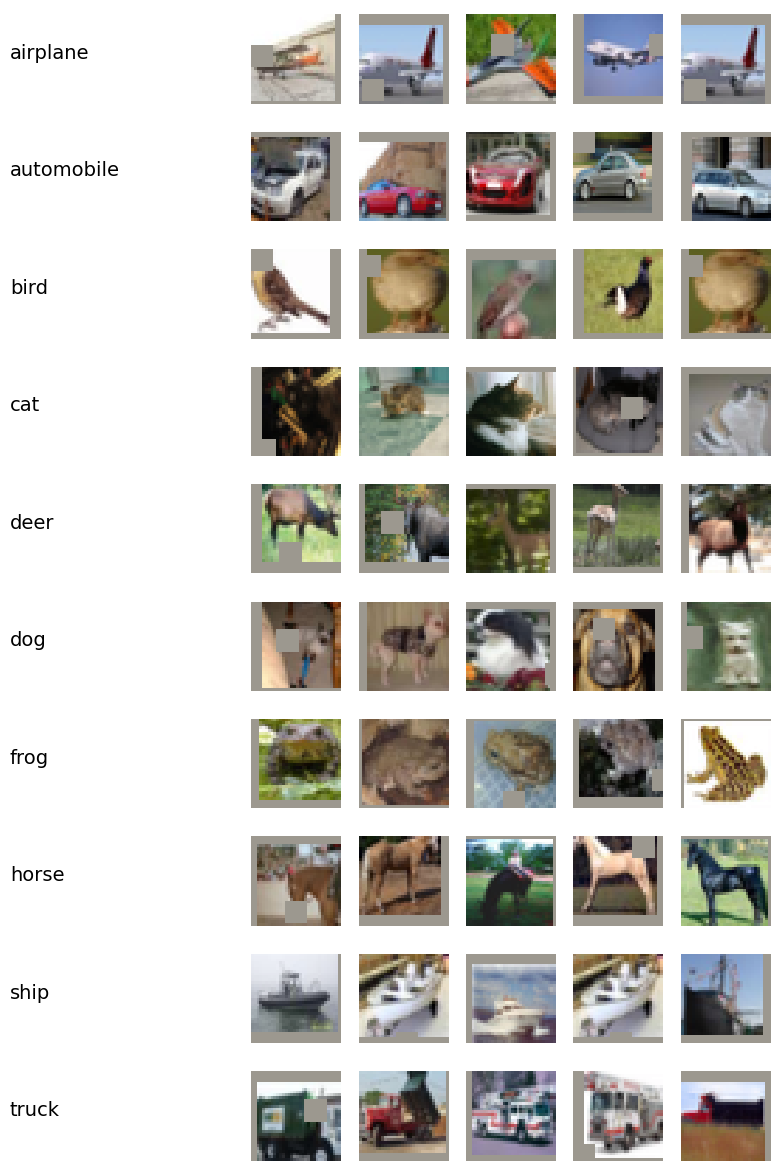

In [21]:
from __future__ import print_function
# channel_means = (0.49196659, 0.48229005, 0.4461573)
# channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)

  for i in range(img.shape[0]):
    img[i] = (img[i]*sdev[i])+mean[i]

  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category.
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [22]:
conv3x3 = partial(nn.Conv2d, bias=False)
bn = nn.BatchNorm2d
bn_momentum = 0.3

class CustomResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.prep = nn.Sequential(
            conv3x3(3, 64, 3, padding=1),
            bn(64,momentum=bn_momentum,),
            nn.ReLU())

        self.layer1 = nn.Sequential(
            conv3x3(64, 128, 3, padding=1),
            nn.MaxPool2d(2, 2),
            bn(128,momentum=bn_momentum),
            nn.ReLU())

        self.res1 = nn.Sequential(
            conv3x3(128, 128, 3, padding=1),
            bn(128,momentum=bn_momentum),
            nn.ReLU(),
            conv3x3(128, 128, 3, padding=1),
            bn(128,momentum=bn_momentum),
            nn.ReLU()
        )

        self.layer2 =  nn.Sequential(
            conv3x3(128, 256,3, padding=1),
            nn.MaxPool2d(2, 2),
            bn(256,momentum=bn_momentum),
            nn.ReLU()
        )

        self.layer3 = nn.Sequential(
            conv3x3(256, 512, 3, padding=1),
            nn.MaxPool2d(2, 2),
            bn(512,momentum=bn_momentum),
            nn.ReLU()
        )

        self.res3 = nn.Sequential(
            conv3x3(512, 512, 3, padding=1),
            bn(512,momentum=bn_momentum),
            nn.ReLU(),
            conv3x3(512, 512, 3, padding=1),
            bn(512,momentum=bn_momentum),
            nn.ReLU()
        )

        self.final_max = nn.MaxPool2d(4)
        self.fc = nn.Linear(in_features = 512, out_features = 10, bias=False)

    def forward(self, x):

        prep = self.prep(x)

        layer1 = self.layer1(prep)
        res1 = self.res1(layer1)
        layer1 = layer1 + res1

        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        res3 = self.res3(layer3)
        layer3 = layer3 + res3

        max = self.final_max(layer3)
        out = max.view(max.size(0),-1)

        fc = self.fc(out)

        out = fc.view(-1,10)

        return out

model = CustomResNet().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

In [23]:
input_tensor = torch.rand(3, 32, 32,device=device)

output_tensor = model(input_tensor.unsqueeze(0)).to(device)

output_tensor, output_tensor.shape

(tensor([[-0.3352, -0.5252, -2.8423,  0.3644,  2.7541,  0.9794, -0.1993,  1.5851,
          -0.5365, -0.0679]], device='cuda:0', grad_fn=<ViewBackward0>),
 torch.Size([1, 10]))

  0%|          | 0/500 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.20E-03


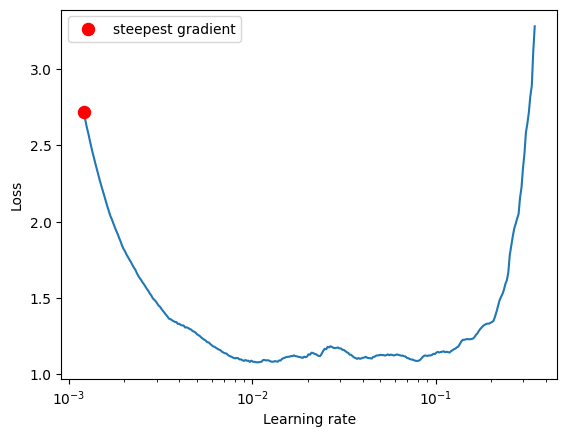

In [24]:
model = CustomResNet().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

criterion = nn.CrossEntropyLoss()

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")

lr_finder.range_test(train_loader, end_lr=10, num_iter=500, step_mode="exp")

lr_finder.plot(log_lr=True)

lr_finder.reset()

In [ ]:
# model = CustomResNet().to(device)

# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# criterion = nn.CrossEntropyLoss()

In [25]:

one_cycle = OneCycleLR(optimizer=optimizer,
                       max_lr=1.20E-03, #1.32E-03, #1.29e-3 ,
                       steps_per_epoch=len(train_loader),
                       epochs=24,
                       pct_start=4/24,
                       div_factor=10,
                       final_div_factor=100,
                       anneal_strategy="linear",
                       three_phase=False,
                       cycle_momentum=True,
                       verbose=0
                       )

In [26]:
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(24):

    train(model=model,
          device=device,
          train_loader=train_loader,
          optimizer=optimizer,
          criterion=criterion,
          train_acc=train_accuracy,
          train_loss=train_losses,
          epoch=epoch+1,
          scheduler=one_cycle)

    test(model, device, test_loader,test_accuracy, test_losses)

  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 1  |  LR: 0.0001200000

Test set: Average loss: 0.00211, Accuracy: 6245/10000 (62.450%)



  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 2  |  LR: 0.0003906905

Test set: Average loss: 0.00178, Accuracy: 6949/10000 (69.490%)



  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 3  |  LR: 0.0006613811

Test set: Average loss: 0.00150, Accuracy: 7400/10000 (74.000%)



  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 4  |  LR: 0.0009320716

Test set: Average loss: 0.00129, Accuracy: 7793/10000 (77.930%)



  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 5  |  LR: 0.0011993884

Test set: Average loss: 0.00099, Accuracy: 8283/10000 (82.830%)



  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 6  |  LR: 0.0011394484

Test set: Average loss: 0.00087, Accuracy: 8512/10000 (85.120%)



  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 7  |  LR: 0.0010795084

Test set: Average loss: 0.00089, Accuracy: 8491/10000 (84.910%)



  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 8  |  LR: 0.0010195684

Test set: Average loss: 0.00079, Accuracy: 8672/10000 (86.720%)



  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 9  |  LR: 0.0009596284

Test set: Average loss: 0.00078, Accuracy: 8705/10000 (87.050%)



  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 10  |  LR: 0.0008996884

Test set: Average loss: 0.00070, Accuracy: 8823/10000 (88.230%)



  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 11  |  LR: 0.0008397484

Test set: Average loss: 0.00077, Accuracy: 8730/10000 (87.300%)



  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 12  |  LR: 0.0007798084

Test set: Average loss: 0.00075, Accuracy: 8731/10000 (87.310%)



  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 13  |  LR: 0.0007198684

Test set: Average loss: 0.00065, Accuracy: 8943/10000 (89.430%)



  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 14  |  LR: 0.0006599284

Test set: Average loss: 0.00069, Accuracy: 8890/10000 (88.900%)



  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 15  |  LR: 0.0005999884

Test set: Average loss: 0.00060, Accuracy: 9028/10000 (90.280%)



  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 16  |  LR: 0.0005400484

Test set: Average loss: 0.00061, Accuracy: 9041/10000 (90.410%)



  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 17  |  LR: 0.0004801084

Test set: Average loss: 0.00063, Accuracy: 9048/10000 (90.480%)



  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 18  |  LR: 0.0004201684

Test set: Average loss: 0.00058, Accuracy: 9067/10000 (90.670%)



  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 19  |  LR: 0.0003602284

Test set: Average loss: 0.00055, Accuracy: 9133/10000 (91.330%)



  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 20  |  LR: 0.0003002884

Test set: Average loss: 0.00052, Accuracy: 9200/10000 (92.000%)



  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 21  |  LR: 0.0002403484

Test set: Average loss: 0.00050, Accuracy: 9200/10000 (92.000%)



  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 22  |  LR: 0.0001804084

Test set: Average loss: 0.00052, Accuracy: 9225/10000 (92.250%)



  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 23  |  LR: 0.0001204684

Test set: Average loss: 0.00051, Accuracy: 9226/10000 (92.260%)



  0%|          | 0/98 [00:00<?, ?it/s]


Epoch num: 24  |  LR: 0.0000605284

Test set: Average loss: 0.00050, Accuracy: 9273/10000 (92.730%)



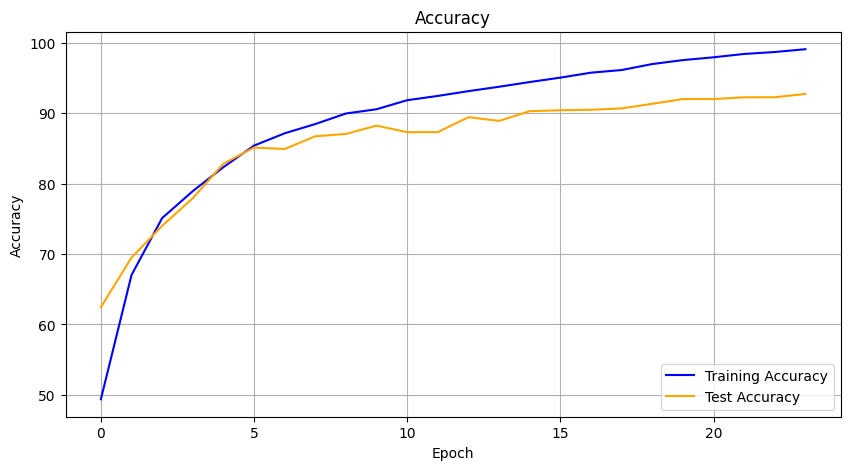

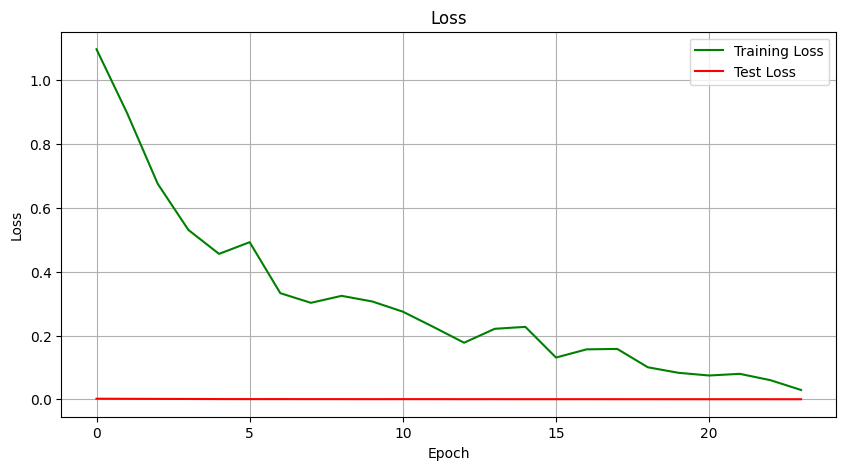

In [27]:
plot_graphs(train_losses=train_losses, train_accuracy=train_accuracy,
            test_losses=test_losses,test_accuracy=test_accuracy)